<a href="https://colab.research.google.com/github/fajemila/zindi-Wheat-g-Challenge/blob/master/cgiar_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import requests, zipfile

#the url and auth_value from the website 
url = "https://api.zindi.africa/v1/competitions/cgiar-wheat-growth-stage-challenge/files/Images.zip"
myobj = {'auth_token': 'wLQWzzvtzxnYfG5kVe6CLxfg'} #use your own

x = requests.post(url, data = myobj,stream=True)
target_path = 'image.zip'


In [2]:
handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

!unzip -qq /content/image.zip

replace Images/EiGOaVe2.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *

In [3]:
# Load and view the data
train = pd.read_csv('/content/drive/My Drive/cgiar/Train.csv')
print(train.shape)
train.head()

(10695, 3)


,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


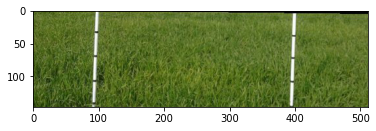

In [4]:
# Loading and viewing an image:
im = PImage.open('/content/Images/nwuCTQKz.jpeg')
plt.imshow(im)

<Figure size 432x288 with 0 Axes>

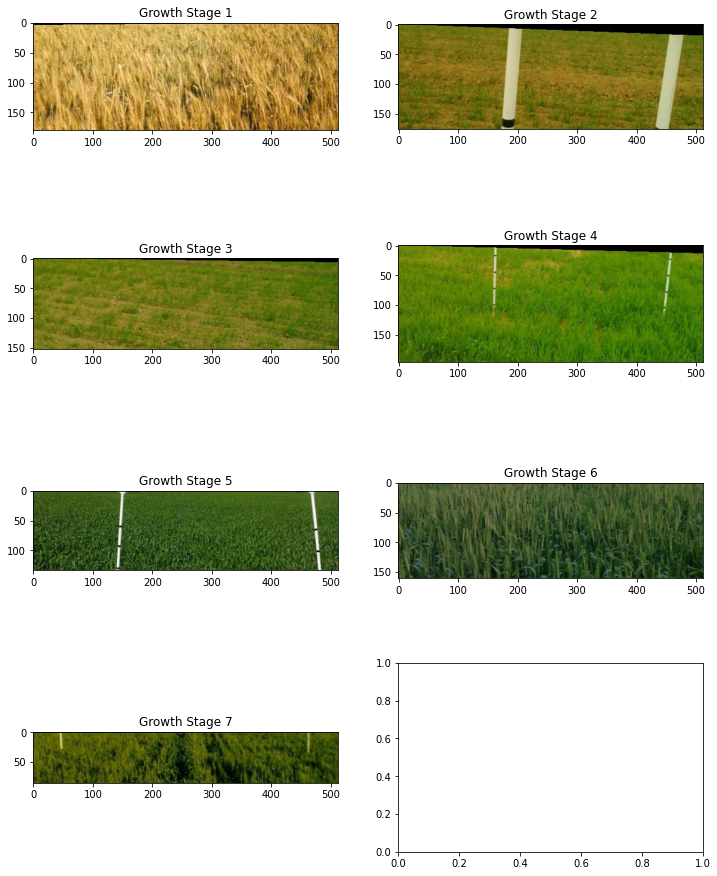

In [5]:
# Plotting an example of each growth stage:
plt.figure()
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

for i, ax in enumerate(axs.flatten()):
  if i+1 in train['growth_stage'].unique(): # If i+1 is a valid growth stage
    im_id = train.loc[(train.growth_stage == i+1)].sample()['UID'].values[0] # Get the ID of an image with the growth stage i+1
    im = PImage.open(f'/content/Images/{im_id}.jpeg')
    ax.imshow(im)
    ax.set_title( f'Growth Stage {i+1}')

In [6]:
train.growth_stage.value_counts()

1    3057
7    2335
4    1712
2    1389
5    1092
3     689
6     421
Name: growth_stage, dtype: int64

In [7]:
train.loc[train.label_quality == 2].shape[0]

2856

In [8]:
train_hq = train.loc[train.label_quality == 2]

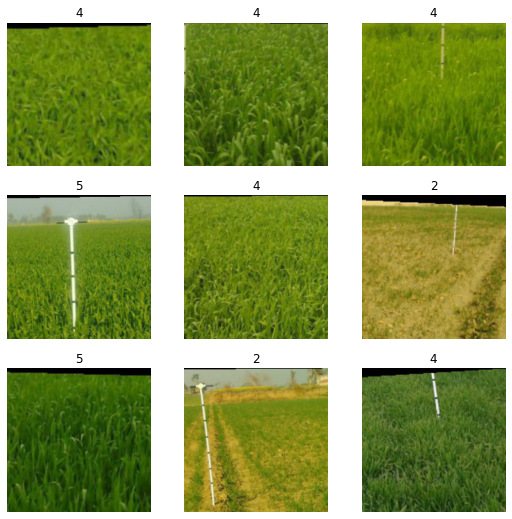

In [9]:
dls = ImageDataLoaders.from_df(train_hq, path='/content/Images/', suff='.jpeg', label_col='growth_stage', item_tfms=Resize(224))
dls.show_batch()

In [11]:
learn = cnn_learner(dls, alexnet, metrics=error_rate)
learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.746190,0.875243,0.309982,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.130600,0.767843,0.273205,00:10
1,1.057722,0.723448,0.260946,00:10
2,0.980551,0.673234,0.255692,00:10
3,0.899101,0.642159,0.246935,00:10
4,0.838665,0.644110,0.241681,00:10
5,0.776115,0.656792,0.248687,00:10
6,0.725142,0.624849,0.248687,00:10
7,0.710865,0.600063,0.246935,00:10
8,0.675711,0.602410,0.245184,00:10
9,0.638187,0.566705,0.248687,00:10


In [12]:
ss = pd.read_csv('/content/drive/My Drive/cgiar/SampleSubmission.csv')
ss.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [13]:
tdl = learn.dls.test_dl(ss) # Make test dataloader

In [14]:
preds = learn.get_preds(dl=tdl) # Get model predictions

In [15]:
preds[0].shape # 5 sets of probabilities - one for each class. The high quality labels must not cover a few of the growth phases

torch.Size([3558, 5])

In [16]:
preds[0][0] # The predictions for the first test image

tensor([4.1021e-03, 4.6482e-04, 2.3974e-01, 1.3431e-01, 6.2138e-01])

In [17]:
learn.dls.vocab # The classes associated with the probabilities output

(#5) [2,3,4,5,7]

In [18]:
# Converting the predicted probabilities into classes:
class_indexes = np.argmax(preds[0], axis=1)
classes = [learn.dls.vocab[idx] for idx in class_indexes]
classes[:3] # We've found the class with the highest probability - these are our predictions

[7, 4, 3]

In [19]:
# Update the submission dataframe with our predictions
ss['growth_stage'] = classes
ss.head()

,UID,growth_stage
0,F3LbWkZq,7
1,6P4wLVzI,4
2,Tn6HIrdS,3
3,EYM5R1TK,4
4,fkcevlA0,5


In [20]:
ss.to_csv('sub1.csv', index=False)

In [22]:
ss = pd.read_csv('/content/drive/My Drive/cgiar/SampleSubmission.csv')
ss['growth_stage'] = (preds[0] * tensor([int(c) for c in learn.dls.vocab])).sum(dim=1)
ss.head() # Now we have outputs that aren't restricted to the integer growth phase numbers

,UID,growth_stage
0,F3LbWkZq,5.989776
1,6P4wLVzI,3.987932
2,Tn6HIrdS,2.877152
3,EYM5R1TK,4.117488
4,fkcevlA0,4.981824


In [23]:
ss.to_csv('sub2.csv', index=False)

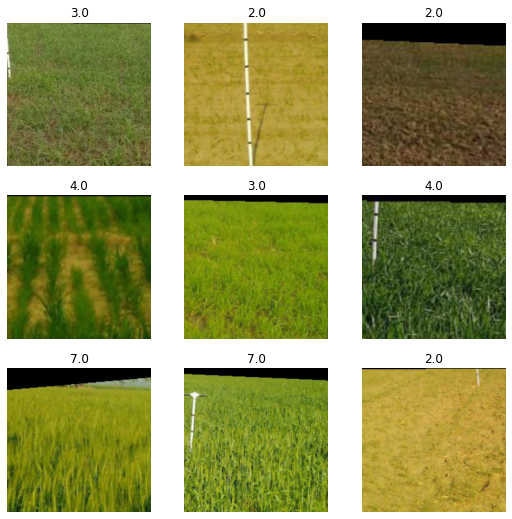

In [25]:
dls = ImageDataLoaders.from_df(train_hq, # train_hq if you only want the smaller high-quality set of images
                               path='/content/Images/', suff='.jpeg', label_col='growth_stage', item_tfms=Resize(224), 
                               y_block=RegressionBlock) # The only other change!
dls.show_batch()

In [34]:
learn = cnn_learner(dls, densenet121, metrics=rmse) # A new metric
learn.fine_tune(30) # Train a little longer

epoch,train_loss,valid_loss,_rmse,time
0,17.165882,10.894685,3.300710,00:23


epoch,train_loss,valid_loss,_rmse,time
0,12.207456,9.824523,3.134410,00:27
1,11.488806,8.653903,2.941752,00:26
2,10.258383,7.098156,2.664236,00:26
3,8.788689,4.619457,2.149292,00:27
4,7.158484,3.208001,1.791089,00:27
5,5.711686,1.798574,1.341109,00:27
6,4.537907,1.087757,1.042956,00:27
7,3.819672,1.139083,1.067279,00:27
8,3.184947,0.947095,0.973188,00:27
9,2.687413,0.836853,0.914797,00:26


In [35]:
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

In [36]:
ss['growth_stage'] = preds[0].numpy() # This time our outputs are in the format we want, so this part is much easier
ss.to_csv('sub3.csv', index=False)

In [37]:
sub2 = pd.read_csv('sub2.csv')
sub3 = pd.read_csv('sub3.csv')
merged = pd.merge(sub2, sub3, on='UID') # Will give two columns of preds - growth_stage_x and growth_stage_y
merged['growth_stage'] = (merged['growth_stage_x'] + merged['growth_stage_y'])/2
merged[['UID', 'growth_stage']].to_csv('sub_ensemble.csv', index=False)